Period bins: [(0.5196910044992892, 0.9428679653058534), (0.9428679653058534, 1.7109500284929424), (1.7109500284929424, 3.1051272115647697), (3.1051272115647697, 5.6349936113539645), (5.6349936113539645, 10.226124192478789), (10.226124192478789, 18.55801713545928), (18.55801713545928, 33.673855903780485)]
Radius bins: [(1.2326312688558734, 1.5900943368240765), (1.5900943368240765, 2.0513361499276512), (2.0513361499276512, 2.6460631133818406), (2.6460631133818406, 3.412825808622526), (3.412825808622526, 4.402272140611028), (4.402272140611028, 5.6789083458002745)]
Removing 0 rows with missing stellar mass
Dataframe size after removal: 3 rows
Filtering out false positives from file CTL_TLS_recovery.csv with length  24
False positive cells removed: 0
Processing 1 unique TICs in temperature range 3000-7000 K


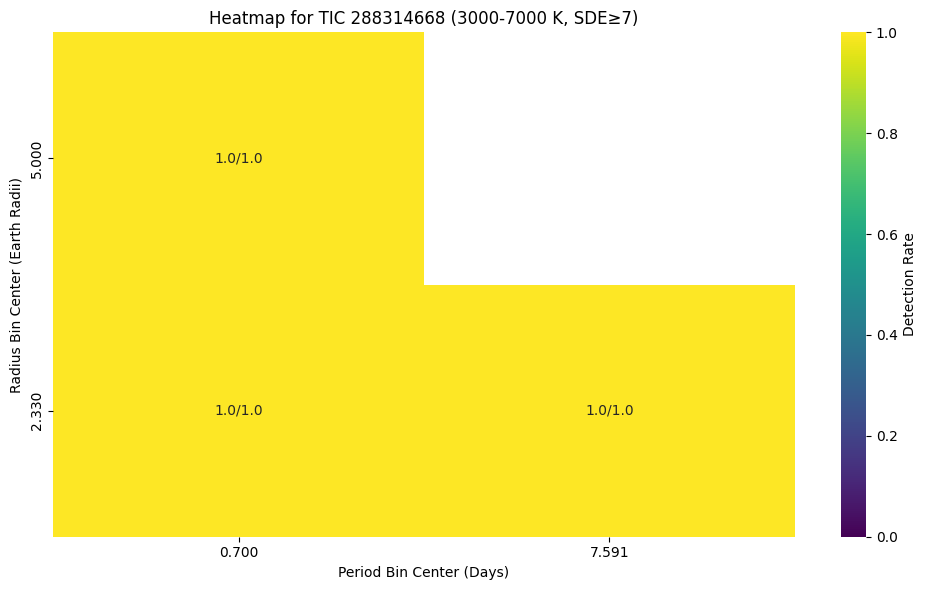

In [2]:
#INDIVIDUAL TIC HEATMAPS

import os
import glob
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

def calc_geometric_transit_probability(df):
    # Cross-match with CTL.csv to add stellar mass
    ctl_df = pd.read_csv('./stellar_params_CTL.csv')
    df = df.copy()

    # Clean TIC column in both dataframes to ensure matching
    df['TIC_clean'] = df['TIC'].str.replace('TIC ', '')
    ctl_df['TIC_clean'] = ctl_df['id'].astype(str).str.replace('TIC ', '')

    # Merge to add stellar mass
    df = df.merge(
        ctl_df[['TIC_clean', 'MASS']], 
        on='TIC_clean', 
        how='left'
    ).rename(columns={'MASS': 'Stellar Mass'})

    # Drop the temporary TIC_clean column
    df = df.drop('TIC_clean', axis=1)

    # Check for missing stellar masses and remove them
    missing_mass = df['Stellar Mass'].isna().sum()
    print(f"Removing {missing_mass} rows with missing stellar mass")
    df = df.dropna(subset=['Stellar Mass'])
    print(f"Dataframe size after removal: {len(df)} rows")

    # Calculate transit probability using actual stellar mass (vectorized)
    R_star = df['Stellar Radius'] * 6.96e8  # Solar radii to meters
    R_planet = df['True Radius (Earth Radii)'] * 6.371e6  # Earth radii to meters
    P = df['True Period (Days)'] * 86400  # Days to seconds
    M_star = df['Stellar Mass'] * 1.989e30  # Solar masses to kg
    G = 6.67430e-11  # Gravitational constant in m³/(kg·s²)

    a = ((P**2 * G * M_star) / (4 * np.pi**2))**(1/3)  # Semi-major axis in meters
    df['Transit Probability'] = (R_star + R_planet) / a

    return df

def filter_out_false_positives(df, sde_threshold):
    false_positive_df = pd.read_csv('./CTL_TLS_recovery.csv')
    print('Filtering out false positives from file CTL_TLS_recovery.csv with length ', len(false_positive_df))


    rows_to_keep = []
    false_positive_count = 0

    for idx, row in df.iterrows():
        tic = row['TIC']
        true_period = float(row['True Period (Days)'])
        
        # Check if this TIC exists in false positives data
        fp_row = false_positive_df[false_positive_df['TIC'] == tic]
        
        is_false_positive = False
        
        # If we found matching TIC in false positive data
        if len(fp_row) > 0:
            try:
                # Parse false positive periods and SDE arrays
                fp_periods = fp_row['TLS Periods array'].iloc[0].replace('[', '').replace(']', '').split()
                fp_periods = [float(p) for p in fp_periods]
                fp_sde = fp_row['TLS SDE > 7 array'].iloc[0].replace('[', '').replace(']', '').split()
                fp_sde = [float(s) for s in fp_sde]
                
                # Get periods above threshold from false positives
                fp_periods_above_threshold = [p for p, s in zip(fp_periods, fp_sde) if s > sde_threshold]
                
                # Check if any false positive periods match our true period or its aliases
                aliases = [true_period, true_period/2, true_period*2, true_period/3, true_period*3]
                is_false_positive = any(0.999 * alias < fp_p < 1.001 * alias 
                                    for fp_p in fp_periods_above_threshold 
                                    for alias in aliases)

                # SET TO 0 method
                if any(any(0.999 * alias < fp_p < 1.001 * alias for alias in aliases) for fp_p in fp_periods_above_threshold):
                    df.loc[idx, 'TLS Periods array'] = '[]'
                    df.loc[idx, 'TLS SDE > 7 array'] = '[]'
                    false_positive_count += 1
            except:
                pass
        
        # Keep the row only if it's NOT a false positive
        if is_false_positive == False:
            rows_to_keep.append(idx)
        # SET TO 0 method
        elif is_false_positive == True:
            rows_to_keep.append(idx)

    # Filter the dataframe
    df_filtered = df.loc[rows_to_keep].reset_index(drop=True)
    print(f"False positive cells removed: {false_positive_count}")

    return df_filtered

def individual_tic_heatmaps(df, sde_threshold, temp_range, periods_bins, radii_bins):
    """
    Generate individual heatmaps for each TIC within a temperature range.
    
    Parameters:
    df: DataFrame with TIC data
    sde_threshold: SDE threshold for detection
    temp_range: tuple (temp_min, temp_max) for stellar temperature filtering
    periods_bins: list of (min, max) tuples for period bins
    radii_bins: list of (min, max) tuples for radius bins
    """
    temp_min, temp_max = temp_range
    
    # Filter based on Stellar Temperature
    temp_lim = (df['Stellar Temperature'] >= temp_min) & (df['Stellar Temperature'] <= temp_max)
    df = df[temp_lim].copy()
    
    # Add geometric transit probability and filter false positives
    df = calc_geometric_transit_probability(df)
    df = filter_out_false_positives(df, sde_threshold)
    
    unique_tics = df['TIC'].unique()
    print(f"Processing {len(unique_tics)} unique TICs in temperature range {temp_min}-{temp_max} K")

    # Calculate bin centers for labeling
    radius_centers = [10**((np.log10(rmin) + np.log10(rmax))/2) for rmin, rmax in radii_bins]
    period_centers = [10**((np.log10(pmin) + np.log10(pmax))/2) for pmin, pmax in periods_bins]

    for tic in unique_tics:
        try:
            # Get all rows for this TIC
            tic_df = pd.DataFrame(columns=['TIC', 'True Radius (Earth Radii)', 'True Period (Days)', 
                                         'Detection', '# trials', 'TLS Periods array', 'TLS SDE > 7 array'])
            tic_rows = df[df['TIC'] == tic]
            
            if tic_rows['True Radius (Earth Radii)'].isnull().all():
                print(f"No valid data for {tic}, skipping...")
                continue
                
            for idx, row in tic_rows.iterrows():
                tic_df = pd.concat([tic_df, pd.DataFrame({
                    'TIC': [tic],
                    'True Radius (Earth Radii)': [row['True Radius (Earth Radii)']],
                    'True Period (Days)': [row['True Period (Days)']],
                    'Detection': [row['Detection']],
                    '# trials': [row['# trials']],
                    'TLS Periods array': [row['TLS Periods array']],
                    'TLS SDE > 7 array': [row['TLS SDE > 7 array']]
                })], ignore_index=True)

            # Create heatmap for this TIC
            heatmap_df = pd.DataFrame(columns=['radius_bin_center', 'period_bin_center', 'Detection'])
            
            for index, row in tic_df.iterrows():
                true_period = float(row['True Period (Days)'])
                true_radius = float(row['True Radius (Earth Radii)'])
                
                # Find which bin this period and radius fall into
                period_bin_center = None
                for i, (pmin, pmax) in enumerate(periods_bins):
                    if pmin <= true_period < pmax:
                        period_bin_center = period_centers[i]
                        break
                
                radius_bin_center = None
                for i, (rmin, rmax) in enumerate(radii_bins):
                    if rmin <= true_radius < rmax:
                        radius_bin_center = radius_centers[i]
                        break
                
                # Skip if outside bin ranges
                if period_bin_center is None or radius_bin_center is None:
                    continue
                
                periods = row['TLS Periods array']
                try:
                    periods = periods.replace('[', '').replace(']', '').split()
                except:
                    continue
                periods = [float(p) for p in periods]
                
                sde = row['TLS SDE > 7 array']
                try:
                    sde = sde.replace('[', '').replace(']', '').split()
                except:
                    continue
                sde = [float(s) for s in sde]
                
                periods_sde_tuple = zip(periods, sde)
                periods_above_threshold = np.array([], dtype=float)
                
                for periods_val, sde_val in periods_sde_tuple:
                    if sde_val > sde_threshold:
                        periods_above_threshold = np.append(periods_above_threshold, periods_val)
                
                # Check if true_period is close to any period above threshold (within 1% relative difference)
                aliases = [true_period, true_period / 2, true_period * 2, true_period / 3, true_period * 3]
                
                if any(0.999 * alias < hp < 1.001 * alias for hp in periods_above_threshold for alias in aliases):
                    detection = 1
                else:
                    detection = 0
                    
                heatmap_df = pd.concat([heatmap_df, pd.DataFrame({
                    'radius_bin_center': [radius_bin_center],
                    'period_bin_center': [period_bin_center],
                    'Detection': [detection] 
                })], ignore_index=True)

            # Convert Detection column to numeric for averaging
            heatmap_df['Detection'] = pd.to_numeric(heatmap_df['Detection'])
            
            # Group by bin centers, counting detections and total trials
            heatmap_counts = heatmap_df.groupby(['radius_bin_center', 'period_bin_center']).agg(
                detections=('Detection', 'sum'),
                trials=('Detection', 'count')
            ).reset_index()

            # Numeric detection rate for coloring
            heatmap_counts['detection_rate'] = heatmap_counts['detections'] / heatmap_counts['trials']

            # Pivot for heatmap coloring
            heatmap_pivot = heatmap_counts.pivot(
                index='radius_bin_center',
                columns='period_bin_center',
                values='detection_rate'
            )

            # Create annotation matrix with "detections/trials" strings
            annot_matrix = heatmap_counts.pivot(
                index='radius_bin_center',
                columns='period_bin_center',
                values='detections'
            ).astype(str) + "/" + heatmap_counts.pivot(
                index='radius_bin_center',
                columns='period_bin_center',
                values='trials'
            ).astype(str)

            plt.figure(figsize=(10, 6))
            sns.heatmap(
                heatmap_pivot,
                annot=annot_matrix,
                fmt='',  # show strings exactly
                cmap='viridis',
                cbar_kws={'label': 'Detection Rate'},
                vmin=0, vmax=1
            )

            plt.gca().invert_yaxis()
            
            # Format axis labels to 3 decimal places
            ax = plt.gca()
            ax.set_xticklabels([f'{float(label.get_text()):.3f}' if label.get_text() else '' 
                               for label in ax.get_xticklabels()])
            ax.set_yticklabels([f'{float(label.get_text()):.3f}' if label.get_text() else '' 
                               for label in ax.get_yticklabels()])
            
            plt.title(f'Heatmap for {tic} ({temp_min}-{temp_max} K, SDE≥{sde_threshold})')
            plt.xlabel('Period Bin Center (Days)')
            plt.ylabel('Radius Bin Center (Earth Radii)')
            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"An error for {tic} occurred: {e}")

# Example usage:
# Load data
csv_files = glob.glob('./tls_results_per_tic/*')
df_list = [pd.read_csv(f) for f in csv_files]
df = pd.concat(df_list, ignore_index=True)
df = df[['TIC', 'True Radius (Earth Radii)', 'True Period (Days)', 'Detection', '# trials', 
         'TLS Periods array', 'TLS SDE > 7 array', 'Stellar Radius', 'Stellar Temperature']]
df = df.drop_duplicates(subset=['TIC', 'True Radius (Earth Radii)', 'True Period (Days)', '# trials'])

#######################
#Binning
# Log-spaced list between 1.4 and 5 (inclusive), in log10 space
radii_centers = np.logspace(np.log10(1.4), np.log10(5), num=6)
# Log-spaced list between 0.7 and 25 (inclusive), in log10 space
periods_centers = np.logspace(np.log10(0.7), np.log10(25), num=7)

# Convert radii_centers and periods_centers to floats with up to 3 decimals
radii_centers = [float(f"{v:.3f}") for v in radii_centers]
periods_centers = [float(f"{v:.3f}") for v in periods_centers]


# Generate bin edges from centers
periods_log = np.log10(periods_centers)
log_step = periods_log[1] - periods_log[0]
period_bin_edges = [10**(periods_log[0] - log_step/2)]
period_bin_edges.extend([10**((periods_log[i] + periods_log[i+1])/2) for i in range(len(periods_log)-1)])
period_bin_edges.append(10**(periods_log[-1] + log_step/2))
periods_bins = [(period_bin_edges[i], period_bin_edges[i+1]) for i in range(len(period_bin_edges)-1)]

radii_log = np.log10(radii_centers)
log_step = radii_log[1] - radii_log[0]
radius_bin_edges = [10**(radii_log[0] - log_step/2)]
radius_bin_edges.extend([10**((radii_log[i] + radii_log[i+1])/2) for i in range(len(radii_log)-1)])
radius_bin_edges.append(10**(radii_log[-1] + log_step/2))
radii_bins = [(radius_bin_edges[i], radius_bin_edges[i+1]) for i in range(len(radius_bin_edges)-1)]

print("Period bins:", periods_bins)
print("Radius bins:", radii_bins)


##########
# Run function for a specific temperature range
sde_threshold = 7
temp_range = (3000, 7000)  # Example temperature range
individual_tic_heatmaps(df, sde_threshold, temp_range, periods_bins=periods_bins, radii_bins=radii_bins)

Problem files: []
Period bins: [(0.5196910044992892, 0.9428679653058534), (0.9428679653058534, 1.7109500284929424), (1.7109500284929424, 3.1051272115647697), (3.1051272115647697, 5.6349936113539645), (5.6349936113539645, 10.226124192478789), (10.226124192478789, 18.55801713545928), (18.55801713545928, 33.673855903780485)]
Radius bins: [(1.2326312688558734, 1.5900943368240765), (1.5900943368240765, 2.0513361499276512), (2.0513361499276512, 2.6460631133818406), (2.6460631133818406, 3.412825808622526), (3.412825808622526, 4.402272140611028), (4.402272140611028, 5.6789083458002745)]
Duplicates dropped: 0
Len of df after dropping duplicates: 3
Number of unique TICs: 1

Removing 0 rows with missing stellar mass
Dataframe size after removal: 3 rows
Filtering out false positives from file CTL_TLS_recovery.csv with length  24
False positive cells: 0


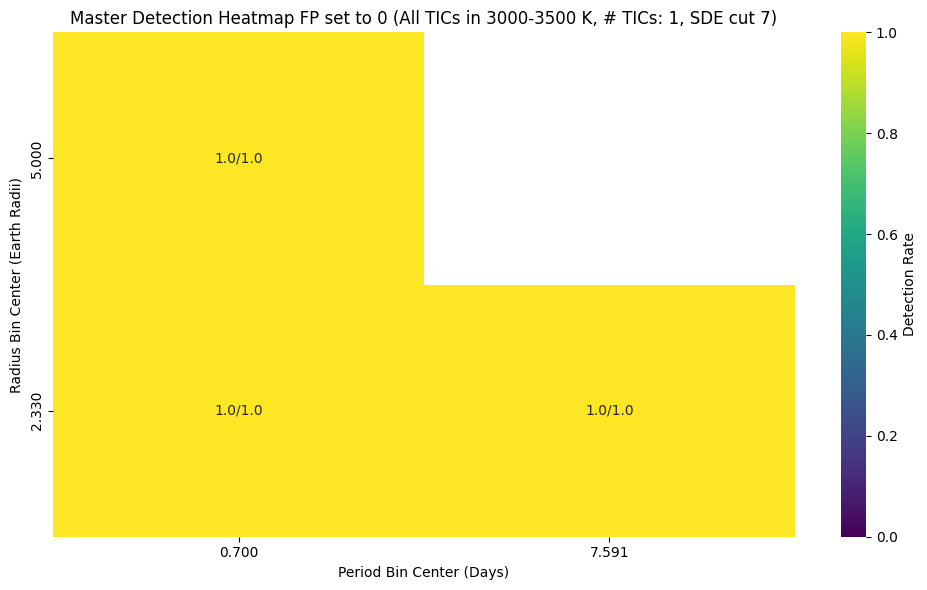

Removing 0 rows with missing stellar mass
Dataframe size after removal: 0 rows
Filtering out false positives from file CTL_TLS_recovery.csv with length  24
False positive cells: 0
No valid data to generate master heatmap.
Removing 0 rows with missing stellar mass
Dataframe size after removal: 0 rows
Filtering out false positives from file CTL_TLS_recovery.csv with length  24
False positive cells: 0
No valid data to generate master heatmap.
Removing 0 rows with missing stellar mass
Dataframe size after removal: 0 rows
Filtering out false positives from file CTL_TLS_recovery.csv with length  24
False positive cells: 0
No valid data to generate master heatmap.
Removing 0 rows with missing stellar mass
Dataframe size after removal: 0 rows
Filtering out false positives from file CTL_TLS_recovery.csv with length  24
False positive cells: 0
No valid data to generate master heatmap.
Removing 0 rows with missing stellar mass
Dataframe size after removal: 0 rows
Filtering out false positives fro

In [1]:
#TEMPERATURE BIN HEATMAPS


import os
import glob
import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt
from scipy.interpolate import griddata

def calc_geometric_transit_probability(df):
    # Cross-match with CTL.csv to add stellar mass
    ctl_df = pd.read_csv('./stellar_params_CTL.csv')
    df = df.copy()

    # Clean TIC column in both dataframes to ensure matching
    df['TIC_clean'] = df['TIC'].str.replace('TIC ', '')
    ctl_df['TIC_clean'] = ctl_df['id'].astype(str).str.replace('TIC ', '')

    # Merge to add stellar mass
    df = df.merge(
        ctl_df[['TIC_clean', 'MASS']], 
        on='TIC_clean', 
        how='left'
    ).rename(columns={'MASS': 'Stellar Mass'})

    # Drop the temporary TIC_clean column
    df = df.drop('TIC_clean', axis=1)
    #print(df)


    # Check for missing stellar masses and remove them
    missing_mass = df['Stellar Mass'].isna().sum()
    print(f"Removing {missing_mass} rows with missing stellar mass")
    df = df.dropna(subset=['Stellar Mass'])
    print(f"Dataframe size after removal: {len(df)} rows")

    # Calculate transit probability using actual stellar mass (vectorized)
    R_star = df['Stellar Radius'] * 6.96e8  # Solar radii to meters
    R_planet = df['True Radius (Earth Radii)'] * 6.378e6  # Earth radii to meters
    P = df['True Period (Days)'] * 86400  # Days to seconds
    M_star = df['Stellar Mass'] * 1.989e30  # Solar masses to kg
    G = 6.67430e-11  # Gravitational constant in m³/(kg·s²)

    a = ((P**2 * G * M_star) / (4 * np.pi**2))**(1/3)  # Semi-major axis in meters
    df['Transit Probability'] = (R_star + R_planet) / a
    return df


def transit_probability_heatmap(df, temp_range, periods_bins, radii_bins):
    # temp_range should be like (3000, 3500)
    temp_min, temp_max = temp_range

    # Filter based on Stellar Temperature
    temp_lim = (df['Stellar Temperature'] >= temp_min) & (df['Stellar Temperature'] <= temp_max)
    df = df[temp_lim].copy()

    #########################
    df = calc_geometric_transit_probability(df)
    ########################

    unique_tics = df['TIC'].unique()

    # Calculate bin centers for labeling
    radius_centers = [10**((np.log10(rmin) + np.log10(rmax))/2) for rmin, rmax in radii_bins]
    period_centers = [10**((np.log10(pmin) + np.log10(pmax))/2) for pmin, pmax in periods_bins]

    # Collect all transit probability results here
    all_transit_rows = []

    for tic in unique_tics:
        try:
            tic_rows = df[df['TIC'] == tic]
            if tic_rows['True Radius (Earth Radii)'].isnull().all():
                continue

            for _, row in tic_rows.iterrows():
                true_period = float(row['True Period (Days)'])
                true_radius = float(row['True Radius (Earth Radii)'])
                
                # Find which bin this period and radius fall into
                period_bin_center = None
                for i, (pmin, pmax) in enumerate(periods_bins):
                    if pmin <= true_period < pmax:
                        period_bin_center = period_centers[i]
                        break
                
                radius_bin_center = None
                for i, (rmin, rmax) in enumerate(radii_bins):
                    if rmin <= true_radius < rmax:
                        radius_bin_center = radius_centers[i]
                        break
                
                # Skip if outside bin ranges
                if period_bin_center is None or radius_bin_center is None:
                    continue

                all_transit_rows.append({
                    'radius_bin_center': radius_bin_center,
                    'period_bin_center': period_bin_center,
                    'Transit Probability': row['Transit Probability']
                })

        except Exception as e:
            print(f"An error for TIC {tic} occurred: {e}")
            continue

    if all_transit_rows:
        transit_df = pd.DataFrame(all_transit_rows)

        # Group by bin centers, average transit probabilities
        transit_counts = transit_df.groupby(
            ['radius_bin_center', 'period_bin_center']
        ).agg(
            avg_transit_prob=('Transit Probability', 'mean'),
            count=('Transit Probability', 'count')
        ).reset_index()

        # Pivot for heatmap
        transit_pivot = transit_counts.pivot(
            index='radius_bin_center',
            columns='period_bin_center',
            values='avg_transit_prob'
        )

        # Create annotation matrix showing transit probability values
        annot_matrix = transit_counts.pivot(
            index='radius_bin_center',
            columns='period_bin_center',
            values='avg_transit_prob'
        ).round(4)  # Round to 4 decimal places for readability

        plt.figure(figsize=(10, 6))
        sns.heatmap(
            transit_pivot,
            annot=annot_matrix,
            fmt='.4f',  # Display transit probability values with 4 decimal places
            cmap='plasma',
            cbar_kws={'label': 'Average Transit Probability'},
            vmin=0, vmax=transit_pivot.max().max()
        )
        plt.gca().invert_yaxis()
        
        # Format axis labels to 3 decimal places
        ax = plt.gca()
        ax.set_xticklabels([f'{float(label.get_text()):.3f}' if label.get_text() else '' 
                           for label in ax.get_xticklabels()])
        ax.set_yticklabels([f'{float(label.get_text()):.3f}' if label.get_text() else '' 
                           for label in ax.get_yticklabels()])
        
        plt.title(f'Transit Probability Heatmap ({temp_min}-{temp_max} K, # TICs: {len(unique_tics)})')
        plt.xlabel('Period Bin Center (Days)')
        plt.ylabel('Radius Bin Center (Earth Radii)')
        plt.tight_layout()
        plt.show()

        # output_dir = './master_heatmaps/'
        # os.makedirs(output_dir, exist_ok=True)
        # output_filename = f'geometry_heatmap_{temp_min}_{temp_max}_K_tics_{len(unique_tics)}.csv'
        # transit_counts.to_csv(os.path.join(output_dir, output_filename), index=False)

    else:
        print("No valid data to generate transit probability heatmap.")

def filter_out_false_positives(df, sde_threshold):
    false_positive_df = pd.read_csv('./CTL_TLS_recovery.csv')
    print('Filtering out false positives from file CTL_TLS_recovery.csv with length ', len(false_positive_df))

    rows_to_keep = []
    false_positive_count = 0


    for idx, row in df.iterrows():
        tic = row['TIC']
        true_period = float(row['True Period (Days)'])
        
        # Check if this TIC exists in false positives data
        fp_row = false_positive_df[false_positive_df['TIC'] == tic]
        
        is_false_positive = False
        
        # If we found matching TIC in false positive data
        if len(fp_row) > 0:
            try:
                # Parse false positive periods and SDE arrays
                fp_periods = fp_row['TLS Periods array'].iloc[0].replace('[', '').replace(']', '').split()
                fp_periods = [float(p) for p in fp_periods]
                fp_sde = fp_row['TLS SDE > 7 array'].iloc[0].replace('[', '').replace(']', '').split()
                fp_sde = [float(s) for s in fp_sde]
                
                # Get periods above threshold from false positives
                fp_periods_above_threshold = [p for p, s in zip(fp_periods, fp_sde) if s > sde_threshold]
                
                # Check if any false positive periods match our true period or its aliases
                aliases = [true_period, true_period/2, true_period*2, true_period/3, true_period*3]
                is_false_positive = any(0.999 * alias < fp_p < 1.001 * alias 
                                    for fp_p in fp_periods_above_threshold 
                                    for alias in aliases)

                # SET TO 0 method
                if any(any(0.999 * alias < fp_p < 1.001 * alias for alias in aliases) for fp_p in fp_periods_above_threshold):
                    df.loc[idx, 'TLS Periods array'] = '[]'
                    df.loc[idx, 'TLS SDE > 7 array'] = '[]'
                    false_positive_count +=1
                #print(f"TIC {tic}: is_false_positive = {is_false_positive}")
            except:
                pass
        
        # Keep the row only if it's NOT a false positive
        if is_false_positive == False:
            rows_to_keep.append(idx)

            ##SET TO 0 method
        elif is_false_positive == True:
            rows_to_keep.append(idx)



    # Filter the dataframe
    df_filtered = df.loc[rows_to_keep].reset_index(drop=True)

    #print(f"Original rows: {len(df)}")
    #print(f"Rows after filtering false positives: {len(df_filtered)}")
    print(f"False positive cells: {false_positive_count}")

    # Replace df with the filtered version
    return df_filtered

def master_heatmap(df, sde_threshold, temp_range, periods_bins, radii_bins):
    # temp_range should be like "3000-3500" or (3000, 3500)
    temp_min, temp_max = temp_range

    # Filter based on Stellar Temperature
    temp_lim = (df['Stellar Temperature'] >= temp_min) & (df['Stellar Temperature'] <= temp_max)
    df = df[temp_lim].copy()

    #########################
    #this removes rows with missing stellar mass
    df = calc_geometric_transit_probability(df)

    df = filter_out_false_positives(df, sde_threshold)
    ########################

    unique_tics = df['TIC'].unique()
    #print(len(unique_tics))

    # Calculate bin centers for labeling
    radius_centers = [10**((np.log10(rmin) + np.log10(rmax))/2) for rmin, rmax in radii_bins]
    period_centers = [10**((np.log10(pmin) + np.log10(pmax))/2) for pmin, pmax in periods_bins]

    # Collect all detection results here
    all_heatmap_rows = []

    for tic in unique_tics:
        try:
            tic_rows = df[df['TIC'] == tic]
            if tic_rows['True Radius (Earth Radii)'].isnull().all():
                print(f"No valid data for {tic}, skipping...")
                continue

            for _, row in tic_rows.iterrows():
                true_period = float(row['True Period (Days)'])
                true_radius = float(row['True Radius (Earth Radii)'])
                
                # Find which bin this period and radius fall into
                period_bin_center = None
                for i, (pmin, pmax) in enumerate(periods_bins):
                    if pmin <= true_period < pmax:
                        period_bin_center = period_centers[i]
                        break
                
                radius_bin_center = None
                for i, (rmin, rmax) in enumerate(radii_bins):
                    if rmin <= true_radius < rmax:
                        radius_bin_center = radius_centers[i]
                        break
                
                # Skip if outside bin ranges
                if period_bin_center is None or radius_bin_center is None:
                    continue

                try:
                    periods = row['TLS Periods array'].replace('[', '').replace(']', '').split()
                    sdes = row['TLS SDE > 7 array'].replace('[', '').replace(']', '').split()
                    periods = [float(p) for p in periods]
                    sdes = [float(s) for s in sdes]
                except:
                    continue

                # Periods with SDE above threshold
                periods_above_threshold = [
                    p for p, s in zip(periods, sdes) if s > sde_threshold
                ]
                # Include aliases (harmonics) for detection check
                aliases = [true_period, true_period / 2, true_period * 2, true_period / 3, true_period * 3]

                detected = any(
                    0.999 * alias < p < 1.001 * alias
                    for alias in aliases
                    for p in periods_above_threshold
                )

                all_heatmap_rows.append({
                    'radius_bin_center': radius_bin_center,
                    'period_bin_center': period_bin_center,
                    'Detection': int(detected),
                    'Transit Probability': row['Transit Probability']
                })
                #print(all_heatmap_rows)

        except Exception as e:
            print(f"An error for TIC {tic} occurred: {e}")
            continue

    if all_heatmap_rows:
        heatmap_df = pd.DataFrame(all_heatmap_rows)
        heatmap_df['Detection'] = pd.to_numeric(heatmap_df['Detection'])

        # Group by bin centers, count detections and trials
        heatmap_counts = heatmap_df.groupby(
            ['radius_bin_center', 'period_bin_center']
        ).agg(
            detections=('Detection', 'sum'),
            trials=('Detection', 'count'),
            transit_prob=('Transit Probability', 'mean')
        ).reset_index()

        # Calculate detection rate for coloring
        heatmap_counts['detection_rate'] = heatmap_counts['detections'] / heatmap_counts['trials']
        
        # Pivot for heatmap coloring
        heatmap_pivot = heatmap_counts.pivot(
            index='radius_bin_center',
            columns='period_bin_center',
            values='detection_rate'
        )

        # Create annotation matrix as "detections/trials"
        annot_matrix = heatmap_counts.pivot(
            index='radius_bin_center',
            columns='period_bin_center',
            values='detections'
        ).astype(str) + "/" + heatmap_counts.pivot(
            index='radius_bin_center',
            columns='period_bin_center',
            values='trials'
        ).astype(str)

        plt.figure(figsize=(10, 6))
        sns.heatmap(
            heatmap_pivot,
            annot=annot_matrix,
            fmt='',  # Display annotations as given
            cmap='viridis',
            cbar_kws={'label': 'Detection Rate'},
            vmin=0, vmax=1
        )
        
        plt.gca().invert_yaxis()
        
        # Format axis labels to 3 decimal places
        ax = plt.gca()
        ax.set_xticklabels([f'{float(label.get_text()):.3f}' if label.get_text() else '' 
                           for label in ax.get_xticklabels()])
        ax.set_yticklabels([f'{float(label.get_text()):.3f}' if label.get_text() else '' 
                           for label in ax.get_yticklabels()])
        
        plt.title(f'Master Detection Heatmap FP set to 0 (All TICs in {temp_min}-{temp_max} K, # TICs: {len(unique_tics)}, SDE cut {sde_threshold})')
        plt.xlabel('Period Bin Center (Days)')
        plt.ylabel('Radius Bin Center (Earth Radii)')
        plt.tight_layout()
        plt.show()

        #save to csv
        output_dir = './master_heatmaps/'
        os.makedirs(output_dir, exist_ok=True)
        output_filename = f'master_heatmap_{temp_min}_{temp_max}_K_sde_{sde_threshold}.csv'
        heatmap_counts.to_csv(os.path.join(output_dir, output_filename), index=False)

    else:
        print("No valid data to generate master heatmap.")


#csv_files = glob.glob("./bf_sep_22_tls_results_per_tic/*.csv")
#csv_files = glob.glob("./bf_oct13_tls_results_per_tic/*.csv")
csv_files = glob.glob("./tls_results_per_tic/*")


############## COLLECT BROKEN FILES ##################
problem_files = []
for f in csv_files:
    try:
        pd.read_csv(f, engine="python")
        
    except Exception as e:
        print(f"Problem reading {f}: {e}")
        problem_files.append(f)
print("Problem files:", problem_files)
csv_files = [f for f in csv_files if f not in problem_files]
df_list = [pd.read_csv(f) for f in csv_files]

#######################################################
#####RUWE FILTER
# # Filter to only keep rows where TIC in stellar_params_CTL_with_ruwe.csv has RUWE < 1.4
# ruwe_df = pd.read_csv('./stellar_params_CTL_with_ruwe.csv')
# ruwe_df['TIC_clean'] = ruwe_df['id'].astype(str).str.replace('TIC ', '')
# ruwe_df = ruwe_df[ruwe_df['ruwe'] < 1.4]

# # Clean TIC in each df_list DataFrame and filter
# filtered_df_list = []
# for d in df_list:
#     d = d.copy()
#     d['TIC_clean'] = d['TIC'].str.replace('TIC ', '')
#     d = d[d['TIC_clean'].isin(ruwe_df['TIC_clean'])]
#     d = d.drop('TIC_clean', axis=1)
#     filtered_df_list.append(d)
# df_list = filtered_df_list
#############

#######################
#Binning
# Log-spaced list between 1.4 and 5 (inclusive), in log10 space
radii_centers = np.logspace(np.log10(1.4), np.log10(5), num=6)
# Log-spaced list between 0.7 and 25 (inclusive), in log10 space
periods_centers = np.logspace(np.log10(0.7), np.log10(25), num=7)

# Convert radii_centers and periods_centers to floats with up to 3 decimals
radii_centers = [float(f"{v:.3f}") for v in radii_centers]
periods_centers = [float(f"{v:.3f}") for v in periods_centers]


# Generate bin edges from centers
periods_log = np.log10(periods_centers)
log_step = periods_log[1] - periods_log[0]
period_bin_edges = [10**(periods_log[0] - log_step/2)]
period_bin_edges.extend([10**((periods_log[i] + periods_log[i+1])/2) for i in range(len(periods_log)-1)])
period_bin_edges.append(10**(periods_log[-1] + log_step/2))
periods_bins = [(period_bin_edges[i], period_bin_edges[i+1]) for i in range(len(period_bin_edges)-1)]

radii_log = np.log10(radii_centers)
log_step = radii_log[1] - radii_log[0]
radius_bin_edges = [10**(radii_log[0] - log_step/2)]
radius_bin_edges.extend([10**((radii_log[i] + radii_log[i+1])/2) for i in range(len(radii_log)-1)])
radius_bin_edges.append(10**(radii_log[-1] + log_step/2))
radii_bins = [(radius_bin_edges[i], radius_bin_edges[i+1]) for i in range(len(radius_bin_edges)-1)]

print("Period bins:", periods_bins)
print("Radius bins:", radii_bins)


##########

df = pd.concat(df_list, ignore_index=True)
df = df[['TIC', 'True Radius (Earth Radii)', 'True Period (Days)', 'Detection', '# trials', 'TLS Periods array', 'TLS SDE > 7 array', 'Stellar Radius', 'Stellar Temperature']]
before = len(df)
df = df.drop_duplicates(subset=['TIC', 'True Radius (Earth Radii)', 'True Period (Days)', '# trials'])
after = len(df)
print(f"Duplicates dropped: {before - after}")
print(f'Len of df after dropping duplicates: {len(df)}')

unique_tics = df['TIC'].unique()
print(f"Number of unique TICs: {len(unique_tics)}\n")

sde_threshold = 7
temp_ranges = [(3000, 3500), (3500, 4000), (4000, 4500), (4500, 5000), (5000, 5500), (5500, 6000), (6000, 6500), (6500, 7000)]#, (7000,8000)]
#temp_ranges = [(3000,7000)]
#temp_ranges = [(t, t + 1000) for t in range(3000, 7000, 1000)]

for temp_range in temp_ranges:
    master_heatmap(df, sde_threshold, temp_range, periods_bins=periods_bins, radii_bins=radii_bins)
    #transit_probability_heatmap(df, temp_range, periods_bins=periods_bins, radii_bins=radii_bins)


Removing 0 rows with missing stellar mass
Dataframe size after removal: 2015 rows
False positive cells: 18
Average radius of detected planets for SDE cut 7 and Stellar Temp range 3000-3500 K: 3.151 Earth radii


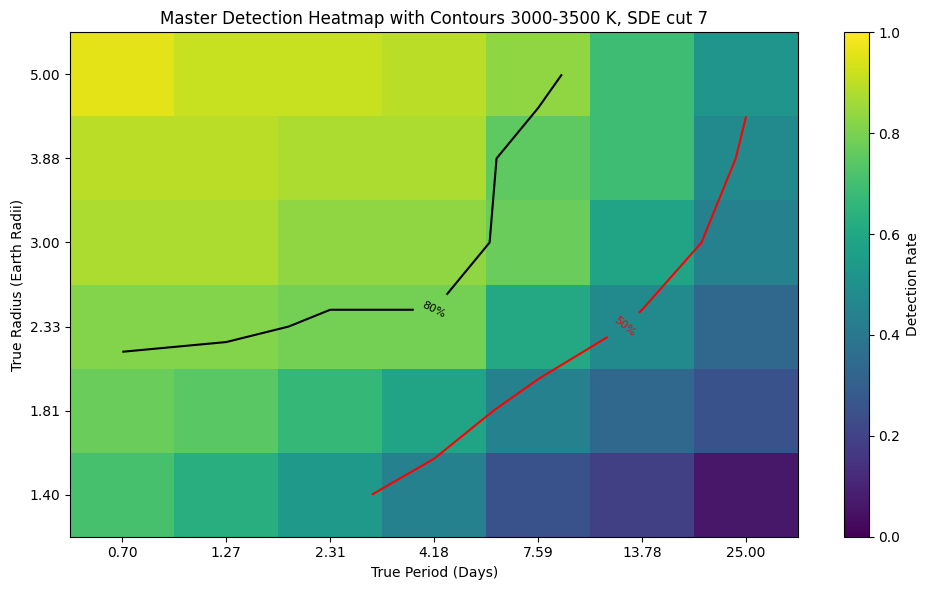

Removing 0 rows with missing stellar mass
Dataframe size after removal: 3317 rows
False positive cells: 36
Average radius of detected planets for SDE cut 7 and Stellar Temp range 3500-4000 K: 3.263 Earth radii


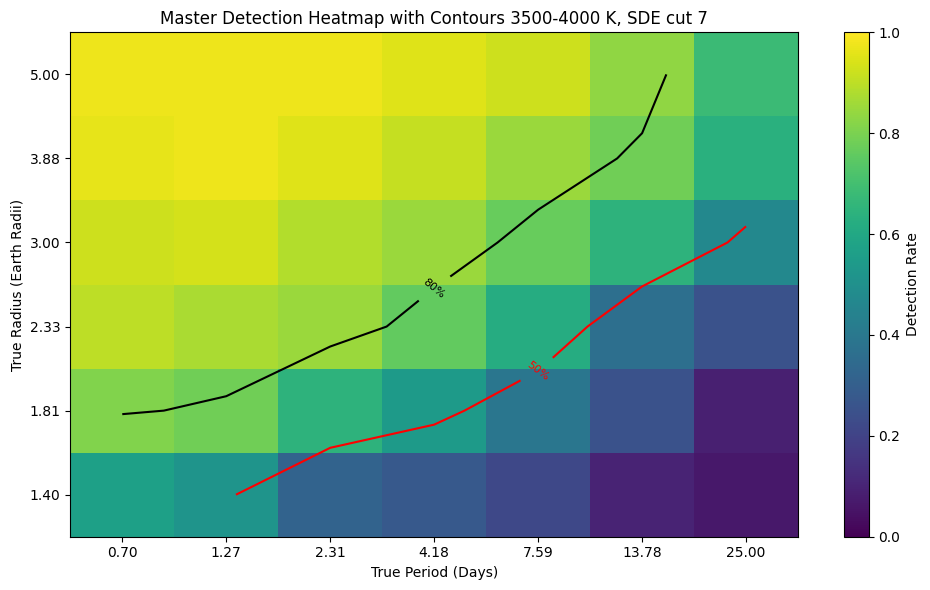

Removing 0 rows with missing stellar mass
Dataframe size after removal: 2562 rows
False positive cells: 42
Average radius of detected planets for SDE cut 7 and Stellar Temp range 4000-4500 K: 3.221 Earth radii


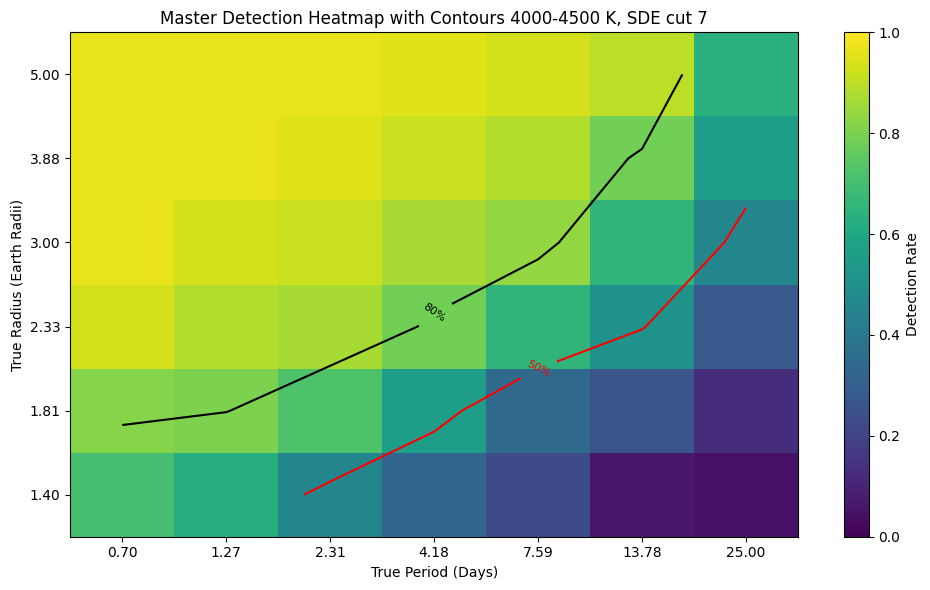

Removing 0 rows with missing stellar mass
Dataframe size after removal: 4622 rows
False positive cells: 48
Average radius of detected planets for SDE cut 7 and Stellar Temp range 4500-5000 K: 3.283 Earth radii


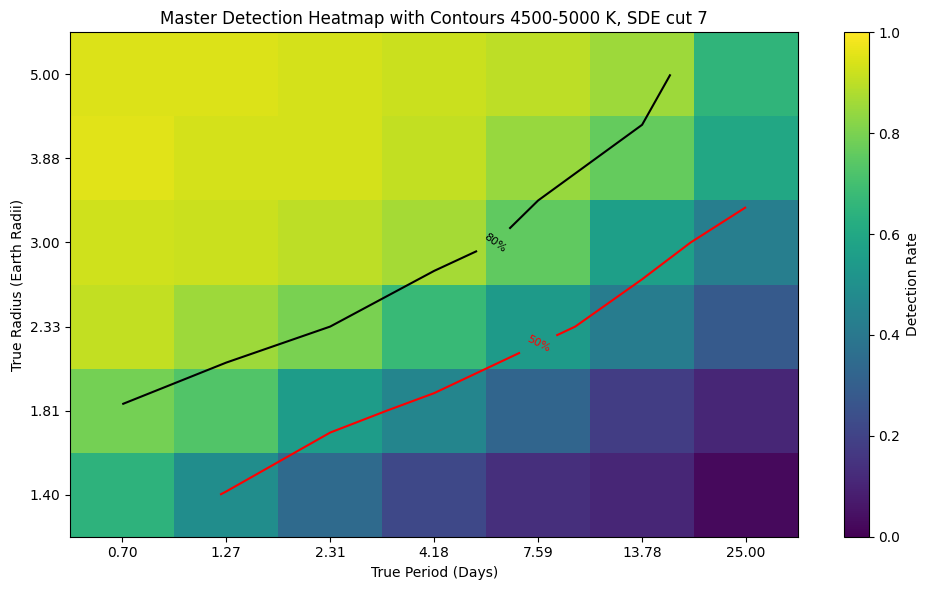

Removing 0 rows with missing stellar mass
Dataframe size after removal: 7055 rows
False positive cells: 84
Average radius of detected planets for SDE cut 7 and Stellar Temp range 5000-5500 K: 3.312 Earth radii


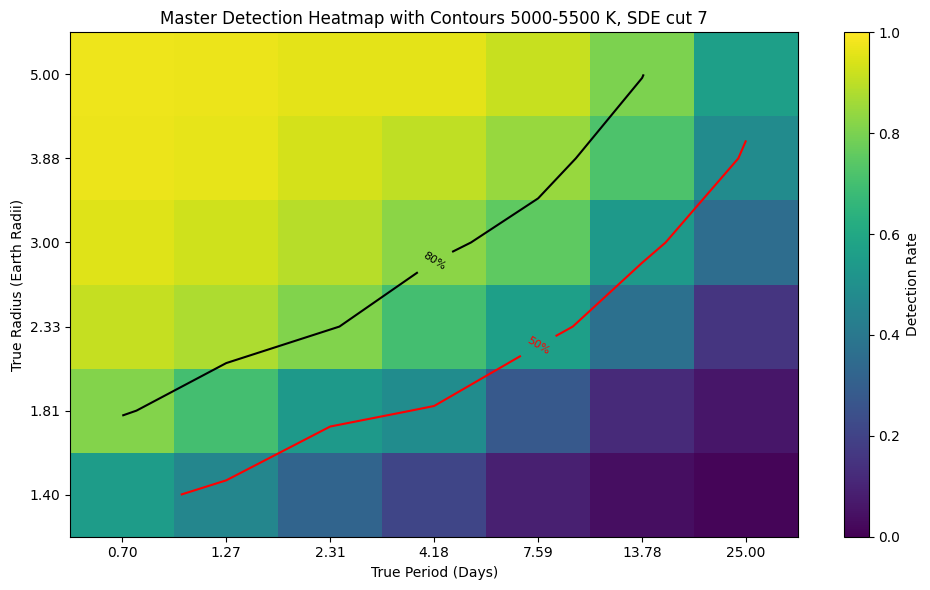

Removing 0 rows with missing stellar mass
Dataframe size after removal: 8770 rows
False positive cells: 108
Average radius of detected planets for SDE cut 7 and Stellar Temp range 5500-6000 K: 3.377 Earth radii


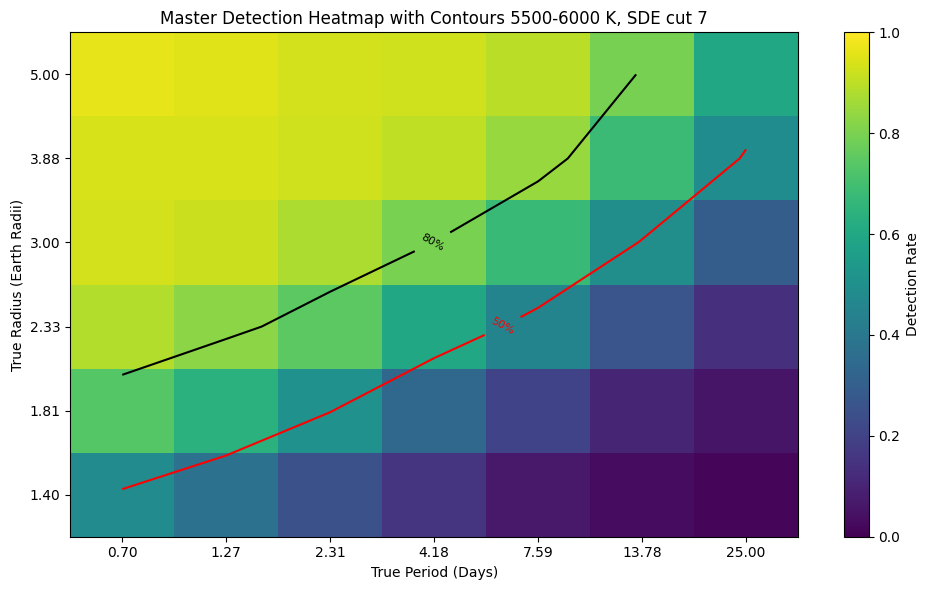

Removing 0 rows with missing stellar mass
Dataframe size after removal: 5711 rows
False positive cells: 36
Average radius of detected planets for SDE cut 7 and Stellar Temp range 6000-6500 K: 3.468 Earth radii


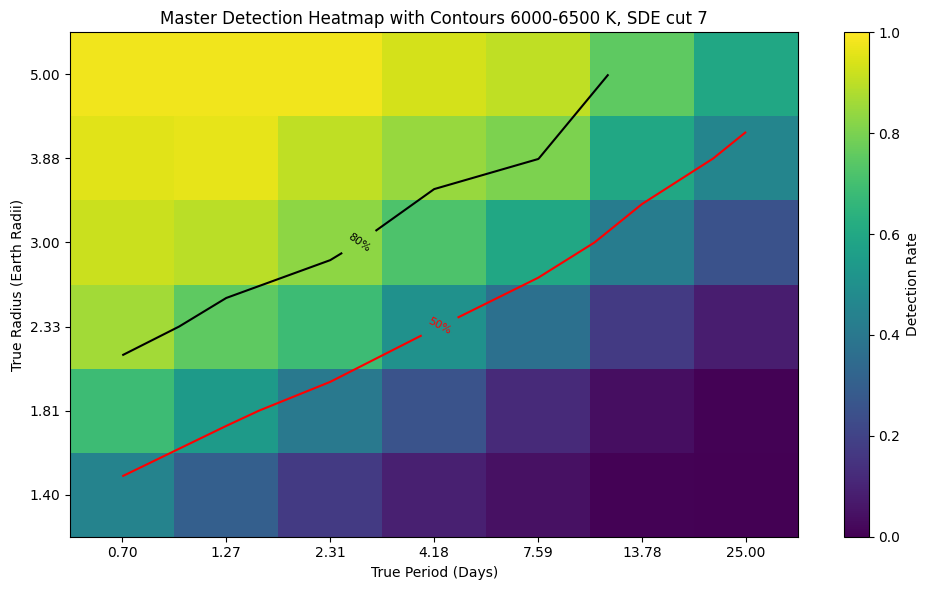

Removing 0 rows with missing stellar mass
Dataframe size after removal: 1176 rows
False positive cells: 12
Average radius of detected planets for SDE cut 7 and Stellar Temp range 6500-7000 K: 3.590 Earth radii


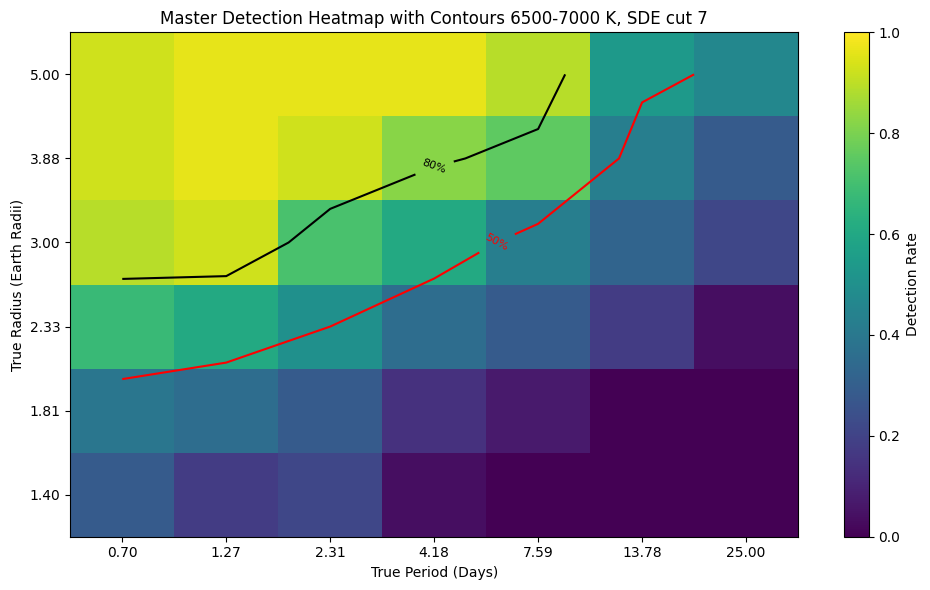

In [ ]:
# TEMPERATURE BIN HEATMAPS WITH CONTOURS


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from scipy.interpolate import griddata

def master_heatmap(df, sde_threshold, temp_range):
    # temp_range should be like (3000, 3500)
    temp_min, temp_max = temp_range

    # Filter based on Stellar Temperature
    temp_lim = (df['Stellar Temperature'] >= temp_min) & (df['Stellar Temperature'] <= temp_max)
    df = df[temp_lim]

    #########################
    #this removes rows with missing stellar mass
    df = calc_geometric_transit_probability(df)

    df = filter_out_false_positives(df, sde_threshold)
    ########################

    unique_tics = df['TIC'].unique()
    #print(len(unique_tics))

    # Collect all detection results here
    all_heatmap_rows = []

    for tic in unique_tics:
        try:
            tic_rows = df[df['TIC'] == tic]
            if tic_rows['True Radius (Earth Radii)'].isnull().all():
                print(f"No valid data for {tic}, skipping...")
                continue

            for _, row in tic_rows.iterrows():
                true_period = float(row['True Period (Days)'])

                try:
                    periods = row['TLS Periods array'].replace('[', '').replace(']', '').split()
                    sdes = row['TLS SDE > 7 array'].replace('[', '').replace(']', '').split()
                    periods = [float(p) for p in periods]
                    sdes = [float(s) for s in sdes]
                except:
                    continue

                # Periods with SDE above threshold
                periods_above_threshold = [
                    p for p, s in zip(periods, sdes) if s > sde_threshold
                ]
                # Include aliases (harmonics) for detection check
                aliases = [true_period, true_period / 2, true_period * 2, true_period / 3, true_period * 3]

                detected = any(
                    0.999 * alias < p < 1.001 * alias
                    for alias in aliases
                    for p in periods_above_threshold
                )

                all_heatmap_rows.append({
                    'True Radius (Earth Radii)': row['True Radius (Earth Radii)'],
                    'True Period (Days)': row['True Period (Days)'],
                    'Detection': int(detected),
                    'Transit Probability': row['Transit Probability']
                })

        except Exception as e:
            print(f"An error for TIC {tic} occurred: {e}")
            continue


    if all_heatmap_rows:
        heatmap_df = pd.DataFrame(all_heatmap_rows)
        heatmap_df['Detection'] = pd.to_numeric(heatmap_df['Detection'])

        # Group by radius and period, count detections and trials
        heatmap_counts = heatmap_df.groupby(
            ['True Radius (Earth Radii)', 'True Period (Days)']
        ).agg(
            detections=('Detection', 'sum'),
            trials=('Detection', 'count')
        ).reset_index()

        # Calculate detection rate for coloring
        heatmap_counts['detection_rate'] = heatmap_counts['detections'] / heatmap_counts['trials']

        # Pivot for heatmap coloring
        heatmap_pivot = heatmap_counts.pivot(
            index='True Radius (Earth Radii)',
            columns='True Period (Days)',
            values='detection_rate'
        )

        avg_detected_radius = heatmap_df.loc[heatmap_df['Detection'] == 1, 'True Radius (Earth Radii)'].mean()
        print(f"Average radius of detected planets for SDE cut {sde_threshold} "
              f"and Stellar Temp range {temp_min}-{temp_max} K: {avg_detected_radius:.3f} Earth radii")

        # --- Plot heatmap with overlayed contours on discrete grid ---
        heatmap_pivot_sorted = heatmap_pivot.sort_index().sort_index(axis=1)

        radius_vals = np.array([1.4, 1.80591136, 2.32951131, 3.00492209, 3.87615924, 5.0])
        period_vals = np.array([0.7, 1.2702963, 2.30521815, 4.18330013, 7.59147243, 13.77631339, 25.0])

        Z = heatmap_pivot_sorted.values  # shape (6,7)

        plt.figure(figsize=(10,6))

        # Use imshow to make uniform cells
        mesh = plt.imshow(
            Z,
            origin='upper',      # so largest radius is on top
            cmap='viridis',
            vmin=0, vmax=1,
            aspect='auto'        # cells uniform
        )

        plt.colorbar(mesh, label='Detection Rate')

        # Overlay contour (same grid)
        X, Y = np.meshgrid(np.arange(len(period_vals)), np.arange(len(radius_vals)))
        CS = plt.contour(
            X, Y, Z,
            #levels=[0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
            #colors=['cyan', 'purple', 'orange', 'green', 'blue', 'red', 'black'],
            levels= [.5,.8],
            colors = ['red', 'black'],
            linewidths=1.5
        )
        plt.clabel(CS, inline=True, fontsize=8, fmt=lambda val: f"{int(val*100)}%")

        # Set tick labels to actual period/radius values
        plt.xticks(np.arange(len(period_vals)), [f"{p:.2f}" for p in period_vals])
        plt.yticks(np.arange(len(radius_vals)), [f"{r:.2f}" for r in radius_vals])

        plt.gca().invert_yaxis()
        plt.xlabel('True Period (Days)')
        plt.ylabel('True Radius (Earth Radii)')
        plt.title(f'Master Detection Heatmap with Contours {temp_min}-{temp_max} K, SDE cut {sde_threshold}')
        plt.tight_layout()
        plt.show()




csv_files = glob.glob("./tls_results_per_tic/*.csv")
df_list = [pd.read_csv(f) for f in csv_files if f not in problem_files]
df = pd.concat(df_list, ignore_index=True)
df = df[['TIC', 'True Radius (Earth Radii)', 'True Period (Days)', 'Detection', '# trials', 'TLS Periods array', 'TLS SDE > 7 array', 'Stellar Radius', 'Stellar Temperature']]
df = df.drop_duplicates(subset=['TIC', 'True Radius (Earth Radii)', 'True Period (Days)', '# trials'])


sde_threshold = 7
temp_ranges = [(3000, 3500), (3500, 4000), (4000, 4500), (4500, 5000), (5000, 5500), (5500, 6000), (6000, 6500), (6500, 7000)]#, (7000,8000)]
#temp_ranges = [(3000,7000)]
#temp_range = (3000, 3500), (5000, 5500), (6500, 7000)

for temp_range in temp_ranges:
    master_heatmap(df, sde_threshold, temp_range)



/var/folders/m_/l_xwjgkd4dn3xl_27hw7d3sh0000gn/T/ipykernel_26625/1314124415.py:90: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([str(t) for t in ax.get_xticks()])


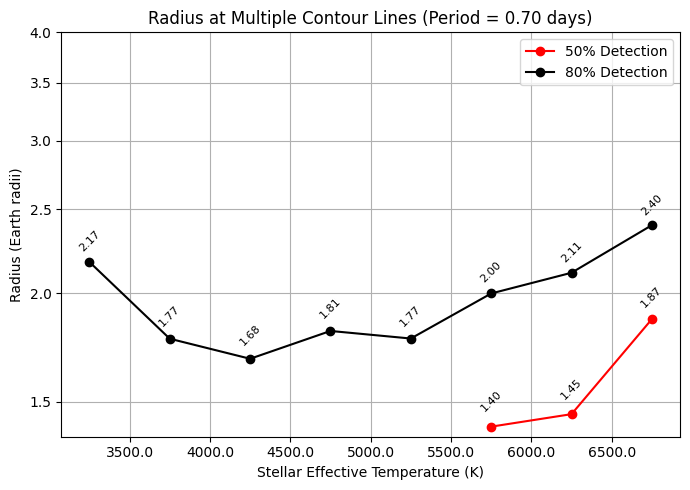

/var/folders/m_/l_xwjgkd4dn3xl_27hw7d3sh0000gn/T/ipykernel_26625/1314124415.py:90: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([str(t) for t in ax.get_xticks()])


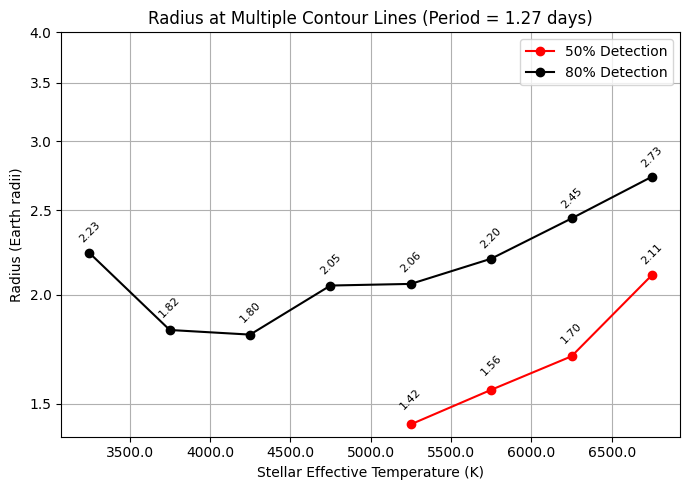

/var/folders/m_/l_xwjgkd4dn3xl_27hw7d3sh0000gn/T/ipykernel_26625/1314124415.py:90: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([str(t) for t in ax.get_xticks()])


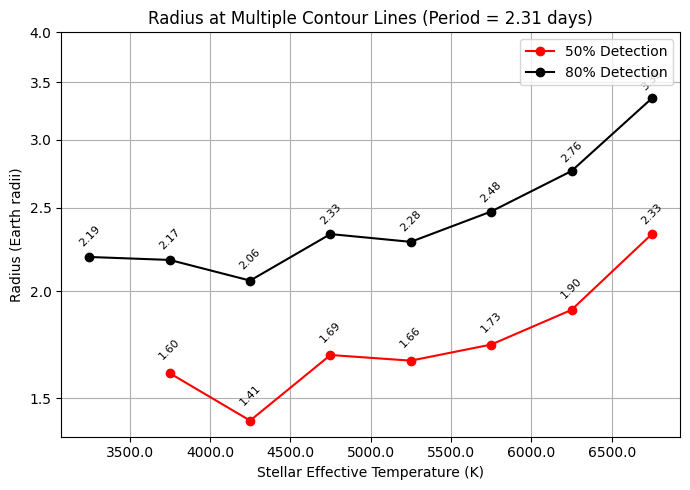

/var/folders/m_/l_xwjgkd4dn3xl_27hw7d3sh0000gn/T/ipykernel_26625/1314124415.py:90: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([str(t) for t in ax.get_xticks()])


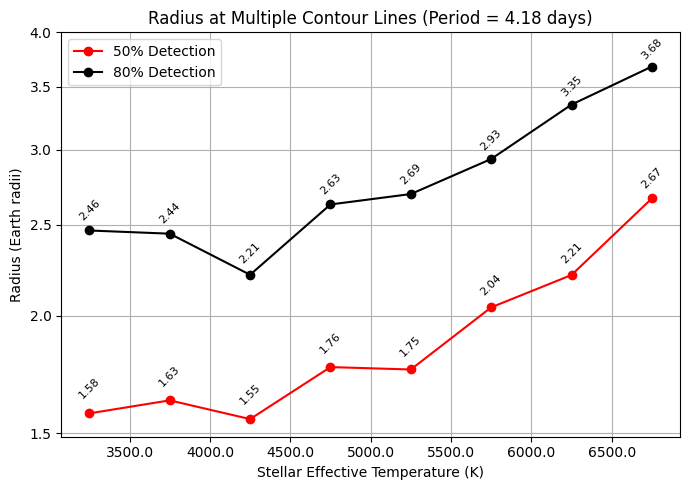

/var/folders/m_/l_xwjgkd4dn3xl_27hw7d3sh0000gn/T/ipykernel_26625/1314124415.py:90: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([str(t) for t in ax.get_xticks()])


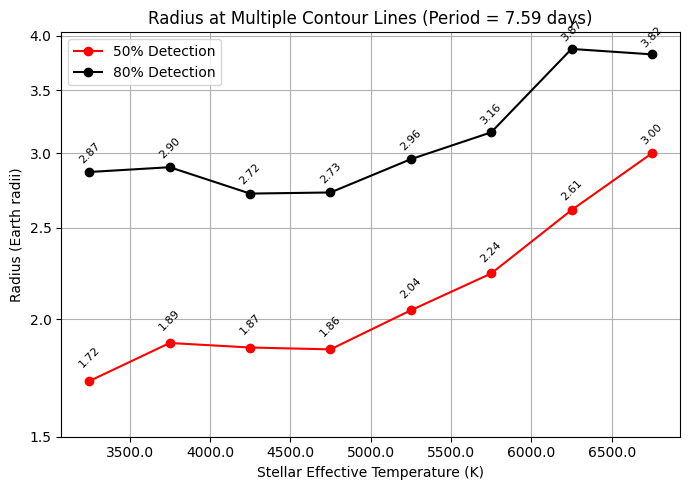

/var/folders/m_/l_xwjgkd4dn3xl_27hw7d3sh0000gn/T/ipykernel_26625/1314124415.py:90: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([str(t) for t in ax.get_xticks()])


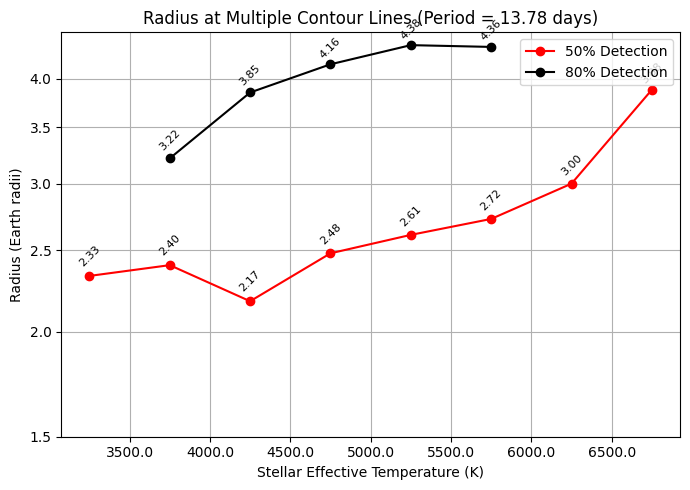

/var/folders/m_/l_xwjgkd4dn3xl_27hw7d3sh0000gn/T/ipykernel_26625/1314124415.py:90: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([str(t) for t in ax.get_xticks()])


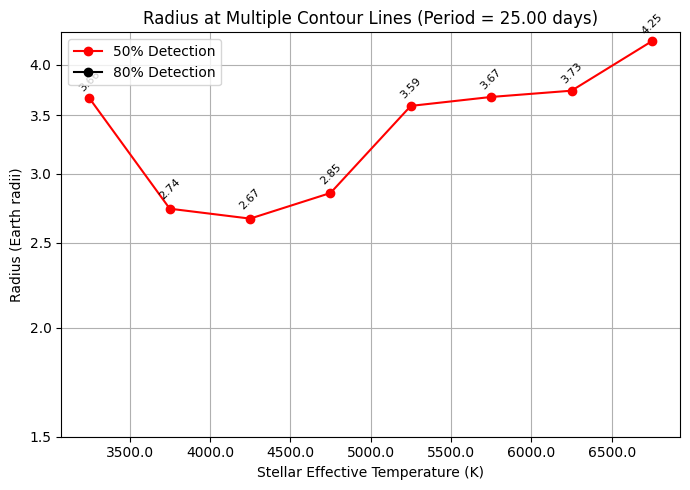

In [ ]:
# TEMPERATURE BINS CONTOUR LINES ANALYSIS

import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import matplotlib.ticker as mticker
from matplotlib.ticker import ScalarFormatter


def get_radius_at_detection(df, temp_range, target_period=4.18, detection_level=0.5):
    """
    Returns the radius corresponding to a given detection rate at a fixed period.
    """
    temp_min, temp_max = temp_range
    df_temp = df[(df['Stellar Temperature'] >= temp_min) & (df['Stellar Temperature'] <= temp_max)]

    if df_temp.empty:
        return None

    # Group by radius & period, compute detection rate
    grouped = df_temp.groupby(['True Radius (Earth Radii)', 'True Period (Days)']).agg(
        detections=('Detection', 'sum'),
        trials=('Detection', 'count')
    ).reset_index()
    grouped['detection_rate'] = grouped['detections'] / grouped['trials']

    # Get rows close to target period (~1%)
    close_periods = grouped[
        (grouped['True Period (Days)'] > 0.99*target_period) &
        (grouped['True Period (Days)'] < 1.01*target_period)
    ]

    if close_periods.empty:
        return None

    # Sort by radius
    close_periods = close_periods.sort_values('True Radius (Earth Radii)')
    radii = close_periods['True Radius (Earth Radii)'].values
    det_rate = close_periods['detection_rate'].values

    if len(radii) < 2:
        return None

    try:
        f_interp = interp1d(det_rate, radii, kind='linear', bounds_error=False)
        radius_at_level = float(f_interp(detection_level))
        return radius_at_level
    except Exception as e:
        print(f"Interpolation failed for {temp_range}, period={target_period}: {e}")
        return None

# --- Parameters ---
detection_levels = [ 0.5, .8]#.6, 0.7, 0.8]  # 30%, 50%, 70%, 90%
colors = ['red', 'black']# 'orange', 'red']
#detection_levels = [.5]
#colors = ['blue']  # Only using 50% detection level for now
temp_ranges = [(3000, 3500), (3500, 4000), (4000, 4500), (4500, 5000),
               (5000, 5500), (5500, 6000), (6000, 6500), (6500, 7000)]

unique_periods = sorted(df['True Period (Days)'].unique())

# --- Loop over all periods ---
for period in unique_periods:
    plt.figure(figsize=(7,5))
    for det_level, color in zip(detection_levels, colors):
        results = []
        for temp_range in temp_ranges:
            r = get_radius_at_detection(df, temp_range, target_period=period, detection_level=det_level)
            if r is not None:
                teff_mid = np.mean(temp_range)
                results.append((teff_mid, r))
        if results:
            teff_vals, radius_vals = zip(*results)
            plt.plot(teff_vals, radius_vals, marker='o', linestyle='-', color=color,
                     label=f"{int(det_level*100)}% Detection")
            # Annotate points
            for t, r in zip(teff_vals, radius_vals):
                if np.isfinite(t) and np.isfinite(r):
                    plt.text(t, r+0.05, f"{r:.2f}", ha='center', va='bottom', fontsize=8, rotation=45)

    plt.xlabel("Stellar Effective Temperature (K)")
    plt.ylabel("Radius (Earth radii)")
    plt.title(f"Radius at Multiple Contour Lines (Period = {period:.2f} days)")
    plt.yscale('log')

    ax = plt.gca()

    # Manually set ticks
    ax.set_yticks([1.5,2,2.5,3,3.5,4])

    # Format ticks as plain numbers
    ax.set_xticklabels([str(t) for t in ax.get_xticks()])
    ax.set_yticklabels([str(t) for t in ax.get_yticks()])



    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

